In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from random import shuffle

from random import sample

In [2]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 20
n_samples= 20

a_range= np.linspace(1.5,2.5,n_samples)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.6,n_samples)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * n_samples

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    probs= [1-x for x in probs]
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)


In [3]:
n_comp = 50

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.047; PC2: 0.011; PC3: 0.011; PC4: 0.011; PC5: 0.01; PC6: 0.01; PC7: 0.01; PC8: 0.01; PC9: 0.01; PC10: 0.01; PC11: 0.01; PC12: 0.009; PC13: 0.009; PC14: 0.009; PC15: 0.009; PC16: 0.009; PC17: 0.009; PC18: 0.009; PC19: 0.008; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.007; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.006; PC44: 0.006; PC45: 0.006; PC46: 0.006; PC47: 0.006; PC48: 0.006; PC49: 0.006; PC50: 0.006
features shape: (400, 50)


In [5]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


In [6]:
#### calculating Fsts between populations.
Pops= [395,390,211]
Sizes= [80,100,30]

def return_fsts(vector_lib,pops):
    H= {pop: [1-(vector_lib[pop,x]**2 + (1 - vector_lib[pop,x])**2) for x in range(vector_lib.shape[1])] for pop in pops}
    Store= []
    for comb in it.combinations(pops,2):
        P= [sum([vector_lib[x,i] for x in comb]) / len(comb) for i in range(vector_lib.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        Fst= np.mean([(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x] for x in range(len(P))])
        
        Store.append([comb,Fst])
    
    ### total fst:
    P= [sum([vector_lib[x,i] for x in pops]) / len(pops) for i in range(vector_lib.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst']),FST

Pairwise, Total_fst= return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.1536


,pops,fst
0,"(395, 390)",0.106763
1,"(395, 211)",0.100811
2,"(390, 211)",0.113284


In [7]:
#### We'll have to first change our fst function.

def return_fsts2(freq_array):
    pops= range(freq_array.shape[0])
    H= {pop: [1-(freq_array[pop,x]**2 + (1 - freq_array[pop,x])**2) for x in range(freq_array.shape[1])] for pop in range(freq_array.shape[0])}
    Store= []

    for comb in it.combinations(H.keys(),2):
        P= [sum([freq_array[x,i] for x in comb]) / len(comb) for i in range(freq_array.shape[1])]
        HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
        per_locus_fst= [[(HT[x] - np.mean([H[p][x] for p in comb])) / HT[x],0][int(HT[x] == 0)] for x in range(len(P))]
        per_locus_fst= np.nan_to_num(per_locus_fst)
        Fst= np.mean(per_locus_fst)

        Store.append([comb,Fst])
    
    
    ### total fst:
    P= [sum([freq_array[x,i] for x in pops]) / len(pops) for i in range(freq_array.shape[1])]
    HT= [2 * P[x] * (1 - P[x]) for x in range(len(P))]
    FST= np.mean([(HT[x] - np.mean([H[p][x] for p in pops])) / HT[x] for x in range(len(P))])
    
    return pd.DataFrame(Store,columns= ['pops','fst'])


In [8]:
#### We're going to do something different now. We'll have two points get closer together in time.
#first chose two
target= [1,2]


labels= []
Fsts_crawl= []
angle_list= []
Distances_crawl= []

for angle in np.arange(1,30,.1):
    
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]

    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    
    new_freqs[new_freqs > 1] = 1
    new_freqs[new_freqs < 0] = 0
    
    Pairwise= return_fsts2(new_freqs)
    
    Distances= []
    for train in it.combinations([x for x in range(new_freqs.shape[0])],2):
        Distances.append(np.sqrt((coords[train[0]][0] - coords[train[1]][0])**2 + (coords[train[0]][1] - coords[train[1]][1])**2) + (coords[train[0]][2] - coords[train[1]][2])**2)
    Distances_crawl.extend(Distances)
    
    labels.extend(Pairwise.pops)
    
    Fsts_crawl.extend(Pairwise.fst)
    angle_list.extend([angle] * Pairwise.shape[0])


Control= np.array([angle_list,Fsts_crawl]).T

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\jgarcia\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



In [9]:
fig_data= [go.Scatter(
x= Distances_crawl,
y= Fsts_crawl,
mode= 'markers',
name= 'fst vs distances'
)
]

layout = go.Layout(
    title= 'Fst vs. distance in vector feature space',
    yaxis=dict(
        title='fsts'),
    xaxis=dict(
        title='eucledian distance in feature space')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [10]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= Control[coords[i],0],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts as a function of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='X')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [11]:
coords= {z:[x for x in range(len(labels)) if labels[x] == z] for z in list(set(labels))}

fig_data= [go.Scatter(
x= [sin(x) for x in Control[coords[i],0]],
y= Control[coords[i],1],
mode= 'lines',
name= 'fst pops {} / {}'.format(i[0],i[1])
) for i in coords.keys()
]

layout = go.Layout(
    title= 'pairwise Fsts against the sinusoid of variable X',
    yaxis=dict(
        title='between population Fst'),
    xaxis=dict(
        title='sin(X)')
)

fig= go.Figure(data=fig_data, layout=layout)
iplot(fig)

In [13]:
def OriginbySNMF(Geno_Q,t):
    """
    Classes individuals according to Group assignment by SNMF
    using user provided threshold (.8 advised). returns dict.
    """
    Geneo = open(Geno_Q,"r")
    Ind = 0
    Groups = recursively_default_dict()
    for line in Geneo:
        line= line.split()
        line= [float(x.strip("\n")) for x in line]
        line= [x / sum(line) for x in line]
        if Ind == 0:
            Groups = {x:[] for x in range(len(line) + 1)}
        bagged = 0
        for value in range(len(line)):
            if line[value] >= t:
                Groups[value].append(line)
                bagged += 1
        if bagged == 0:
            Groups[len(line)].append(line)
        Ind += 1
    return Groups



Geno_Q = "Complementary_data/sNMF_out3K.Q"
Geneo = OriginbySNMF(Geno_Q,.9)


In [51]:
#### let's create our populations
## we'll sample randomly from each of the set created from the admixture analysis.
Sizes= [120,70,100,50]

Origins= {x: sample(Geneo[x], Sizes[x]) for x in Geneo.keys()}

Origins= {x: {y:Origins[x][y] for y in range(len(Origins[x]))} for x in Origins.keys()}

#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


In [52]:
labels= [0,1,2]
target= [1,2]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 5e-2

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

def extract_profiles(global_data,target_ind_dict):
    ## estimate the bandwith
    params = {'bandwidth': np.linspace(np.min(global_data), np.max(global_data),20)}
    grid = GridSearchCV(KernelDensity(algorithm = "ball_tree",breadth_first = False), params,verbose=0)
    
    cluster_profiles= {x:[] for x in target_ind_dict.keys()}
    
    
    ## perform MeanShift clustering.
    combine= {}
    for bull in target_ind_dict.keys():
        Quanted_set= global_data[target_ind_dict[bull],:]
        grid.fit(Quanted_set)
        kde = grid.best_estimator_

        P_dist = kde.score_samples(Quanted_set)
        Fist = kde.score_samples(global_data)

        ## Normalizing log-likelihood estimates by those of the reference set.
        Fist = scipy.stats.norm(np.mean(P_dist),np.std(P_dist)).cdf(Fist)
        cluster_profiles[bull].append(Fist)

    
    return cluster_profiles
    


for angle in np.arange(1,10,.1):
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]

    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)

    data= []

    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')

    data= pca2.fit_transform(data)

    profiles= extract_profiles(data,target_indx)
    
    ### store stuff.
    Windows[bl]= profiles


Windows= {1:Windows}

In [53]:
ind_to_group[323]

[3, 33]

In [14]:
def Merge_class(Ref_profiles,focus_indicies,Out,Diff_threshold,X_threshold):
    Blocks_genome = recursively_default_dict()
    
    for CHR in Ref_profiles.keys():
        print(CHR)
        Points = sorted(Out[CHR].keys())
        Likes = Ref_profiles[CHR]
        N_pops= len(Likes[[x for x in Likes.keys()][0]])
        Pop_labels= Likes[[x for x in Likes.keys()][0]].keys()
        print("number of reference populations: {0}".format(N_pops))
        Likes = {x:[Likes[bl][x] for bl in sorted(Likes.keys())] for x in Pop_labels}
        Likes = {x:np.array([y[0] for y in Likes[x]]) for x in Likes.keys()}

        Topo = []
        
        #range_Parents = [x + Aro.shape[0] for x in range(Daddy.shape[0])]
        #range_Crossed = [x for x in range(Aro.shape[0])]
        
        for acc in focus_indicies:
            Guys = np.array([Likes[x][:,acc] for x in Pop_labels])
            Guys = np.nan_to_num(Guys)
            Guys = [[[y,0][int(y<=X_threshold)] for y in x] for x in Guys]
            
            Test = [int(x <= X_threshold) for x in np.amax(np.array(Guys),axis = 0)]     
            
            #
            Guys = np.array(Guys).T
            
            maxim = np.argmax(Guys,axis = 1)
            where_X = [x for x in range(Guys.shape[0]) if Test[x] == 1]
            
            #
            Consex = [x for x in it.combinations(range(N_pops),2)]
            if Consex:
                for h in range(len(maxim)):
                    CL = []
                    for j in Consex:
                        Diff = Guys[h,j]
                        if maxim[h] not in j or len([x for x in Diff if x < X_threshold]) > 0:
                            continue
                        if max(Diff) <= X_threshold:
                            Diff = 0
                        else:
#                            Diff = int(len([x for x in Diff if x <= Diff_threshold]) == 1)
                            Diff = abs(max(Diff)) / abs(min(Diff))
                            Diff = int(Diff > Diff_threshold)
                        
                        if Diff == 0:
                            CL.append(j)
                    
                    if len(CL) == 2:
                        maxim[h] = 7
                    if len(CL) == 1:
                        maxim[h] = sum(CL[0]) + N_pops
            
            maxim[where_X] = N_pops
            
            if not Consex:
                for h in range(len(maxim)):
                    maxim[h] = int(10*Guys[h,0])    
            
            
            Topo.append(maxim + 1)
        
        
        Topo = np.array(Topo).T
        
        Clove = {CHR:{Points[x]:Topo[x,] for x in range(len(Points))}}
        
        Blocks_genome.update(Clove)
    
    return Blocks_genome


def compress_ideo(df,chromosome_list):
    
    new_set = []
    
    for CHR in range(len(chromosome_list)):
        
        Chr = int(re.search('Region_(.+?)_',chromosome_list[CHR]).group(1))
        sub = df[df.chrom == chromosome_list[CHR]]
        Coordinates = sorted(sub.start)
        Size = sub.shape[0]
        start = min(df.start)
        First = sub.gieStain.iloc[0]
        for index in range(len(Coordinates)):
            row = sub[sub.start == Coordinates[index]]
            if index == 0:
                continue
            if index == (Size - 1):
                if row.gieStain.iloc[0] == First:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                else:
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
                    new_set.append([chromosome_list[CHR],start,Out[Chr][max(df.start)],First])
            else:
                if row.gieStain.iloc[0] == First:
                    continue
                else:
                    new_set.append([chromosome_list[CHR],start,row.start.iloc[0]-1,First])
                    First = row.gieStain.iloc[0]
                    start = row.start.iloc[0]
    
    new_set = pd.DataFrame(new_set,columns = ['chrom', 'start', 'end', 'gieStain'])
    return new_set


# Here's the function that we'll call for each dataframe (once for chromosome
# ideograms, once for genes).  The rest of this script will be prepping data
# for input to this function
#
def chromosome_collections(df, y_positions, height,  **kwargs):
    """
    Yields BrokenBarHCollection of features that can be added to an Axes
    object.
    Parameters
    ----------
    df : pandas.DataFrame
        Must at least have columns ['chrom', 'start', 'end', 'color']. If no
        column 'width', it will be calculated from start/end.
    y_positions : dict
        Keys are chromosomes, values are y-value at which to anchor the
        BrokenBarHCollection
    height : float
        Height of each BrokenBarHCollection
    Additional kwargs are passed to BrokenBarHCollection
    """
    del_width = False
    if 'width' not in df.columns:
        del_width = True
        df['width'] = df['end'] - df['start']
    for chrom, group in df.groupby('chrom'):
        
        yrange = (y_positions[chrom], height)
        xranges = group[['start', 'width']].values
        yield BrokenBarHCollection(
            xranges, yrange, facecolors=group['colors'], **kwargs)
    if del_width:
        del df['width']


def return_ideogram(ideo):
    # Height of each ideogram
    chrom_height = 1

    # Spacing between consecutive ideograms
    chrom_spacing = 0

    # Height of the gene track. Should be smaller than `chrom_spacing` in order to
    # fit correctly
    gene_height = 0.0

    # Padding between the top of a gene track and its corresponding ideogram
    gene_padding = 0.0


    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing



    # Keep track of the y positions for ideograms and genes for each chromosome,
    # and the center of each ideogram (which is where we'll put the ytick labels)
    ybase = 0
    chrom_ybase = {}
    gene_ybase = {}
    chrom_centers = {}

    # Iterate in reverse so that items in the beginning of `chromosome_list` will
    # appear at the top of the plot
    for chrom in chromosome_list[::-1]:
        chrom_ybase[chrom] = ybase
        chrom_centers[chrom] = ybase + chrom_height / 2.
        gene_ybase[chrom] = ybase - gene_height - gene_padding
        ybase += chrom_height + chrom_spacing
    

    # Colors for different chromosome stains
    color_lookup = {
        'red': [255, 0, 0],
        'yellow': [255, 255, 0],
        'blue': [0, 0, 255],
        'orange': [255, 165, 0],
        'green': [50, 205, 50],
        'black': [0, 0, 0],
        'purple': [128, 0, 128],
        'silver': [211, 211, 211],
    }

    # Add a new column for colors
    
    ideo['colors'] = ideo['gieStain'].apply(lambda x: tuple([round(y / float(255),1) for y in color_lookup[x]]))
    # Add a new column for width
    ideo['width'] = ideo.end - ideo.start

    # Width, height (in inches)
    figsize = (10, 30)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    # Now all we have to do is call our function for the ideogram data...
    print("adding ideograms...")
    for collection in chromosome_collections(ideo, chrom_ybase, chrom_height, edgecolors=None, linewidths= 0):
        ax.add_collection(collection)

    # Axes tweaking
    ax.set_xticks([x for x in range(min(ideo.start),max(ideo.end),int(1000))])
    plt.xticks(fontsize = 5,rotation = 90)
    ax.tick_params(axis = 'x',pad = 10)

    ax.tick_params(axis='y', which='major', pad=30)
    ax.set_yticks([chrom_centers[i] for i in chromosome_list])
    ax.set_yticklabels(chromosome_list, fontsize = 5)
    ax.axis('tight')
    return fig



In [49]:
Origins.keys()


dict_keys([0, 1, 2, 3])

In [54]:

#### begin by compressing assignments by individuals. Lightens the load of the following plot.

import re
chromosome_list= []
chromosomes= [1]

for hap in Whose:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = compress_ideo(ideo,chromosome_list)


adding ideograms...


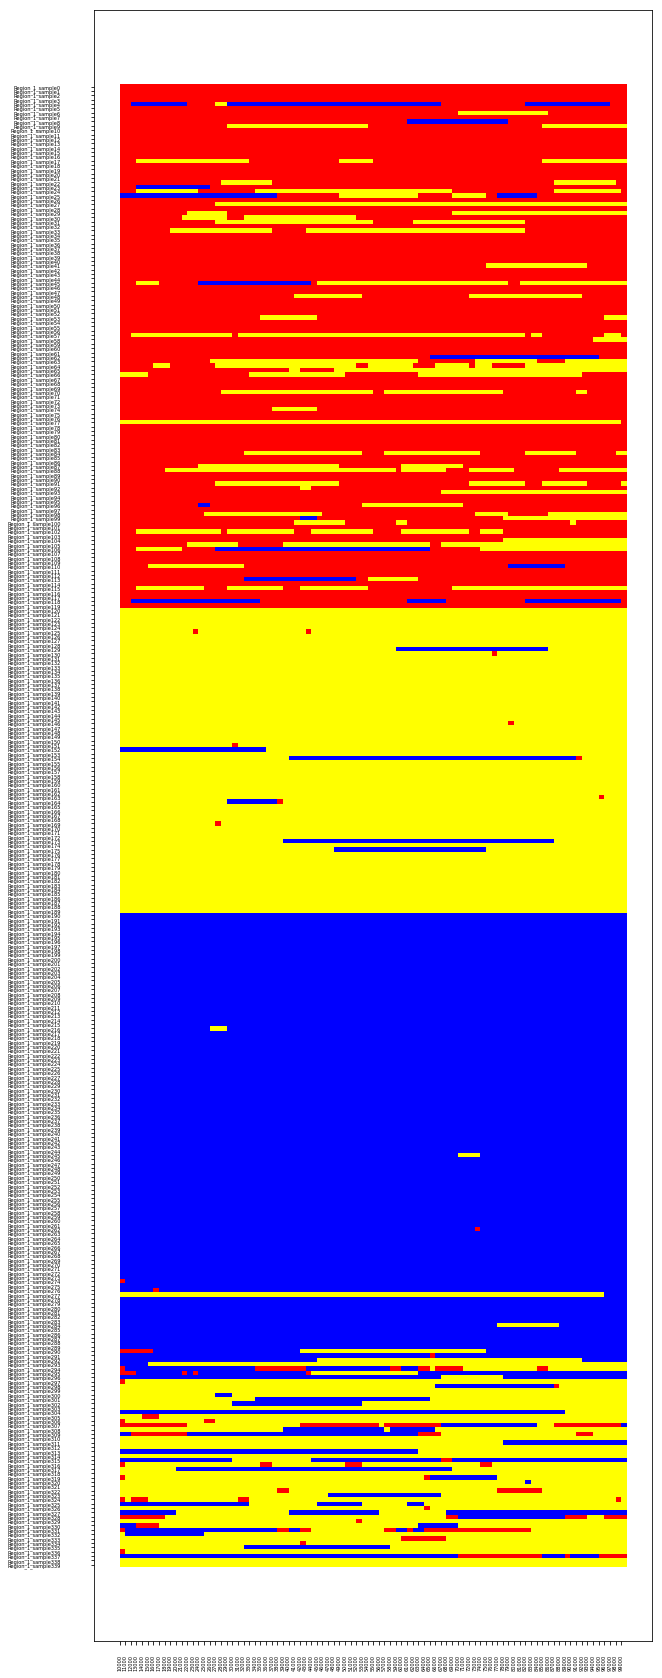

In [55]:
fig= return_ideogram(ideo)


In [56]:
focus_indexes= [x for x in range(len(label_vector))]

Comparison_threshold= 5
Outlier_threshold= 1e-5
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks = Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

1
number of reference populations: 3


In [57]:
Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(label_vector)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks[Chr][bl][here] - 1]] for bl in sorted(Blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)


In [58]:
#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = compress_ideo(ideo_kde,chromosome_list)


adding ideograms...


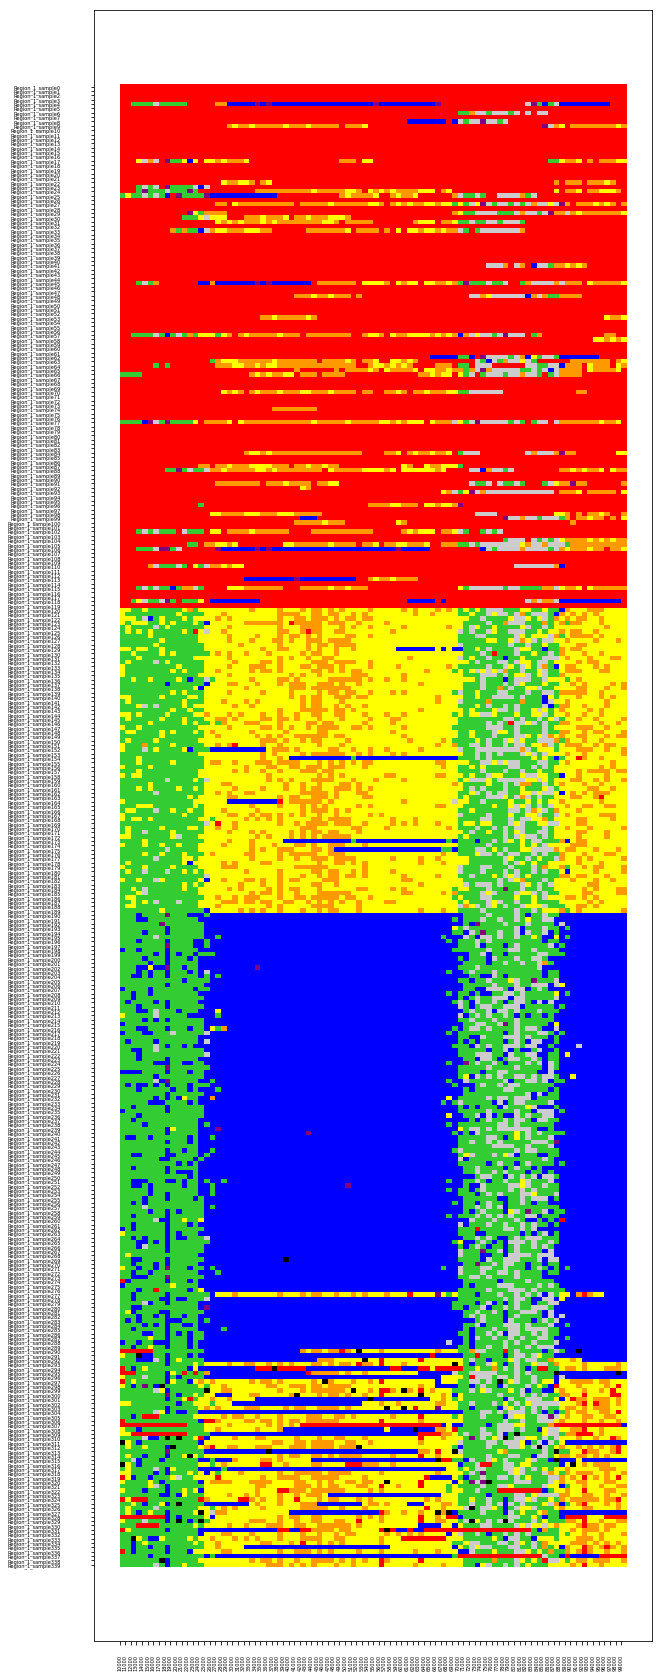

In [59]:
fig= return_ideogram(ideo_kde)

In [106]:
### Write LAMP-file

Refs= [1,2]
Admx= [3]
Home= 'LAMP-HAP_test'
Home_kde= 'KDE_sim'

def lamp_input(Out, Refs, Admx, haplotypes, Home):
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_lamp.pos"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(s) + '\n')
    posfile.close()
    
    for pop in Refs:
        filename= Home + "/pop{}.ref".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()
    
    for pop in Admx:
        filename= Home + "/pop{}.txt".format(pop)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        Output= open(filename,'w')
        for acc in label_indicies[pop]:
            Output.write(''.join([str(x*2) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()


def kde_input(Out, Refs, Admx, haplotypes, Home):
    
    Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
    Snps= [int(x) for x in it.chain(*Snps)]
    
    filename= Home + "/test_markers.txt"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    posfile= open(filename,'w')
    for s in sorted(Snps):
        posfile.write(str(chromosomes[0]) + '\t' + '\t'.join(['0']*2) + '\t' + str(s) + '\tA\tC\t' + '\n')
    posfile.close()
    
    ## geno file
    Geno_out= 'kde_test.geno'
    os.makedirs(os.path.dirname(Geno_out), exist_ok=True)
    Geno_out= open(Geno_out,'w')
    
    ## reference index file
    ref_file= Home + "/test_ref.txt"
    os.makedirs(os.path.dirname(ref_file), exist_ok=True)
    Output_ref= open(ref_file,'w')
    
    ## admixed index file
    admx_file= Home + "/test_admx.txt"
    os.makedirs(os.path.dirname(admx_file), exist_ok=True)
    Output_admx= open(admx_file,'w')
    
    ## fam file
    fam_file= Home + '/kde_test.fam'
    os.makedirs(os.path.dirname(admx_file), exist_ok=True)
    Output_admx= open(admx_file,'w')
    
    d= 0
    
    for pop in Refs:
        
        for acc in label_indicies[pop]:
            ## write to geno
            Geno_out.write(''.join([str(x) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()
    
    for pop in Admx:
        
        for acc in label_indicies[pop]:
            Geno_out.write(''.join([str(x*2) for x in haplotypes[Whose[acc]]]) + '\n')
        Output.close()



import os
lamp_input(Out,Refs,Admx,haplotypes,Home)



In [2]:
'\t'.join(['0'] * 4) + '\t' + '1' + '\n'

'0\t0\t0\t0\t1\n'

'1\t0\t0\t355\tA\tC\t\n'